# Recovering IAQ Data with Imputation
Trying to see how much data we can recover from the participants in the UTx000 study.

In [1]:
import warnings
warnings.filterwarnings('ignore')

%load_ext autoreload
%autoreload 2

# Package Import

In [2]:
import os
import sys
sys.path.append('../')

from src.visualization import visualize

import pandas as pd
pd.set_option('display.max_columns', 200)
import numpy as np

from datetime import datetime, timedelta

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates

from statsmodels.tsa.arima.model import ARIMA
from sklearn.experimental import enable_iterative_imputer 
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestRegressor

import random
import missingno as msno

from scipy import stats
from sklearn.linear_model import LinearRegression

<a id='toc'></a>

# Table of Contents

1. [Diagnosing Data Completeness](#diagnosing)
2. [Remove at Random](#remove_random)
3. [Remove Periods at Random](#remove_periods_random)
4. [Save](#save)

---

<a id='diagnosing'></a>

[Back to ToC](#toc)
# Diagnosing Participant Data Completeness
The first step is to identify the carying levels of data completeness from each of our participants. Some key metrics to consider are:
* **Percent Complete**: The percent of missing data in total, aggregated by sensor.
* **Maximum Period of Missingness**: The maximum number of consecutive data points that are missing, aggregated by sensor.

## Data Import and Cleaning

In [3]:
# importing
data = pd.read_csv("../data/processed/beacon-ux_s20.csv",parse_dates=["timestamp"],index_col=0,infer_datetime_format=True)
data.drop(["lux","no2","pm1_mass","rh","beiwe","fitbit","redcap"],axis="columns",inplace=True) # unecessary iaq and ID columns
data.drop([col for col in data.columns if col.endswith("number")],axis="columns",inplace=True) # pm number
data.head()

,tvoc,co,co2,pm2p5_mass,pm10_mass,temperature_c,beacon
timestamp,,,,,,,
2020-06-08 13:00:00,65.783786,19.834244,NaN,24.767709,1.935866,16.244700,1
2020-06-08 13:02:00,65.973889,19.815803,NaN,25.379307,1.940782,16.257887,1
2020-06-08 13:04:00,66.832566,19.799258,NaN,24.874103,1.937115,16.269523,1
2020-06-08 13:06:00,67.746837,19.775693,NaN,24.503767,1.933971,16.279865,1
2020-06-08 13:08:00,68.488233,19.761017,NaN,24.824221,1.936699,16.289119,1


In [4]:
def get_beacon(df,beacon_number=1):
    """
    Returns data from the given beacon
    """
    return df[df["beacon"] == beacon_number]

In [5]:
temp = get_beacon(data,6)
temp.tail()

,tvoc,co,co2,pm2p5_mass,pm10_mass,temperature_c,beacon
timestamp,,,,,,,
2020-08-31 23:52:00,474.375699,0.133383,943.425117,16.843721,0.0,NaN,6
2020-08-31 23:54:00,472.730131,0.134951,941.153914,17.017218,0.0,NaN,6
2020-08-31 23:56:00,470.906444,0.130623,938.916023,17.144607,0.0,NaN,6
2020-08-31 23:58:00,469.088195,0.131011,936.693818,17.039647,0.0,NaN,6
2020-09-01 00:00:00,467.010792,0.122014,934.498690,16.315049,0.0,NaN,6


## Summarizing Missing Data

In [6]:
def summarize_missing(df,params=["tvoc","co","co2","pm2p5_mass","pm10_mass","temperature_c"]):
    """
    Summarizes the missing data from each sensor and the max period
    """
    # creating result dict
    res = {param: [] for param in params}
    res["beacon"] = []
    # looping through beacons
    for bb in df["beacon"].unique():
        df_bb = df[df["beacon"] == bb]
        df_bb.dropna(subset=params,how="all",inplace=True) # dropping primarily NaN data appended to the end 
        # appending results to dict
        for ix, val in zip(df_bb.isna().sum().index,df_bb.isna().sum()):
            if ix != "beacon":
                res[ix].append(val/len(df_bb))
        res["beacon"].append(bb)
    
    return pd.DataFrame(res).set_index("beacon")

In [7]:
summarize_missing(data)

,tvoc,co,co2,pm2p5_mass,pm10_mass,temperature_c
beacon,,,,,,
1,0.021422,0.001476,0.045507,0.005645,0.005848,0.102420
5,0.012558,0.000578,0.011254,0.013620,0.013750,0.030109
6,0.018760,0.000666,0.013019,0.022961,0.000042,1.000000
7,0.005769,0.002470,0.017227,0.010072,0.000287,0.010741
10,0.013944,0.000340,0.015999,0.009700,0.009227,0.010853
11,0.006789,0.000000,0.008910,0.015812,0.000113,0.023535
15,0.007043,0.000396,0.019809,0.011157,0.009258,0.004431
16,0.000000,0.001021,0.000000,0.037912,0.031788,0.010207
17,0.009613,0.000342,0.037941,0.010614,0.010077,0.008247


## Summarize Missing Data Periods
Now we look specifically at the periods of missing data.

In [8]:
def summarize_missing_periods(df,params=["tvoc","co","co2","pm2p5_mass","pm10_mass","temperature_c"],verbose=False):
    """
    Summarizes the periods of missing data from each parameter
    """
    res = {param: [] for param in params}
    res["beacon"] = []
    for bb in df["beacon"].unique():
        res_bb = {param: [] for param in params}
        df_bb = df[df["beacon"] == bb]
        if verbose:
            msno.matrix(df_bb)
            plt.show()
            plt.close()
        df_bb.dropna(subset=params,how="all",inplace=True) # dropping primarily NaN data appended to the end 
        for param in params:
            df_bb_param = df_bb[[param]]
            df_bb_null = df_bb_param[df_bb_param[param].isnull()]
            if verbose:
                print(df_bb_null)
            df_bb_null.fillna(2,inplace=True)
            new_df = df_bb_null.reset_index()
            new_df["end"] = new_df["timestamp"]
            new_df = (
                new_df.groupby(
                    # Find where index does not follow pattern of 2 minute intervals
                    new_df['timestamp'].diff().gt(pd.Timedelta(minutes=2)).cumsum()
                ).agg({
                    # Get the last index value and the average of the column values
                    'timestamp': 'first', 'end': 'last', param: 'sum'
                }).set_index('timestamp').rename_axis(index=None)  # restore index
            )
            res_bb[param] = new_df[param].values
            if verbose:
                print(f"{bb} - {param} - {len(new_df)}")
        for param in params:
            res[param].append(res_bb[param])
        
        res["beacon"].append(bb)
            
    return pd.DataFrame(res)

In [9]:
a = summarize_missing_periods(data,verbose=False)

In [10]:
def plot_comp_hist(periods,params=["tvoc","co","co2","pm2p5_mass","pm10_mass","temperature_c"],check_limit=120,fig_limit=1440,save=False):
    """
    plots a comprehensive look at the missing periods
    """
    fig, axes = plt.subplots(2,3,figsize=(12,6),sharex=True,sharey=True)
    for param, ax in zip(params,axes.flat):
        complete_list = []
        for i in range(len(periods)):
            complete_list += list(periods[param][i])

        less_than_limit = [i for i in complete_list if i <= fig_limit]
        check_limit_list = [i for i in complete_list if i <= check_limit]
        print(f"Percent less than {check_limit}: {round(len(check_limit_list)/len(complete_list)*100,2)}")
        ax.hist(less_than_limit,bins=np.arange(0,1450,60),color="cornflowerblue",edgecolor="black",label=param)
        for loc in ["top","right"]:
            ax.spines[loc].set_visible(False)
            
        ax.tick_params(labelsize=12)
        ax.set_xticks(np.arange(0,1450,480))
        ax.set_title(f"{visualize.get_label(param)}",fontsize=14)
        ax.text(1440,200,f"\nn (<1440): {len(less_than_limit)}\nn (all): {len(complete_list)}",va="top",ha="right",fontsize=12)
        
    fig.add_subplot(111, frame_on=False)
    plt.tick_params(labelcolor="none", bottom=False, left=False)
    plt.xlabel("Period (minutes)",labelpad=8,fontsize=16)
    plt.ylabel("Count",labelpad=8,fontsize=16)
        
    if save:
        plt.savefig(f"../reports/figures/imputation/periods-{fig_limit}-hist.pdf",bbox_inches="tight")
    plt.show()
    plt.close()

Percent less than 80: 56.33
Percent less than 80: 89.33
Percent less than 80: 38.08
Percent less than 80: 64.58
Percent less than 80: 70.77
Percent less than 80: 53.56


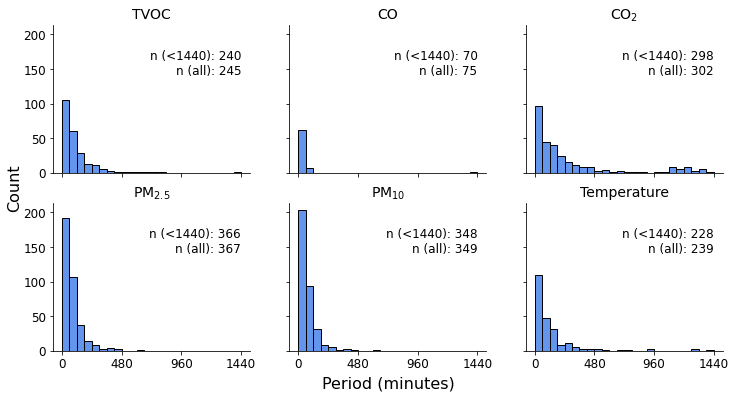

In [11]:
plot_comp_hist(a,check_limit=80,save=False)

[Back to Data Import](#data_import)

---

<a id='remove_random'></a>

[Back to ToC](#toc)
# Imputing per Beacon
Now that we have a sense of the data we can reasonably impute, we need to go through each device and impute the data. The idea is to:
* Identify periods of missing data per device
* Impute across the entire dataset
* Re-insert missing data for periods longer than the limits we identified earlier.

We use the following models for the given parameters:
* **ARMA**: CO$_2$, Temperature, TVOCs
* **missForest**: PM$_{2.5}$, CO

## Identifying Periods of Missing Data

In [12]:
def aggregate_missing_periods(df,params=["tvoc","co","co2","pm2p5_mass","pm10_mass","temperature_c"],verbose=False):
    """
    Summarizes the periods of missing data from each parameter
    """
    res = {"beacon":[], "start":[], "end":[], "period":[], "param":[]}
    for bb in df["beacon"].unique():
        df_bb = df[df["beacon"] == bb]
        if verbose:
            msno.matrix(df_bb)
            plt.show()
            plt.close()
        df_bb.dropna(subset=params,how="all",inplace=True) # dropping primarily NaN data appended to the end 
        for param in params:
            df_bb_param = df_bb[[param]]
            df_bb_null = df_bb_param[df_bb_param[param].isnull()]
            if verbose:
                print(df_bb_null)
            df_bb_null.fillna(2,inplace=True)
            new_df = df_bb_null.reset_index()
            new_df["end"] = new_df["timestamp"]
            new_df["start"] = new_df["timestamp"]
            new_df = (
                new_df.groupby(
                    # Find where index does not follow pattern of 2 minute intervals
                    new_df['timestamp'].diff().gt(pd.Timedelta(minutes=2)).cumsum()
                ).agg({
                    # Get the last index value and the average of the column values
                    'start': 'first', 'end': 'last', param: 'sum'
                })  # restore index
            )
            for i in range(len(new_df)):
                for df_key, dict_key in zip(["start","end",param],["start","end","period"]):
                    res[dict_key].append(new_df[df_key][i])
                    
                res["beacon"].append(bb)
                res["param"].append(param)
            
    return pd.DataFrame(res)

In [13]:
aggregate_missing_periods(data)

,beacon,start,end,period,param
0,1,2020-06-19 04:36:00,2020-06-19 05:10:00,36.0,tvoc
1,1,2020-06-26 13:36:00,2020-06-26 14:28:00,54.0,tvoc
2,1,2020-07-02 09:54:00,2020-07-02 11:18:00,86.0,tvoc
3,1,2020-07-02 12:22:00,2020-07-02 13:30:00,70.0,tvoc
4,1,2020-07-04 08:04:00,2020-07-04 09:26:00,84.0,tvoc
...,...,...,...,...,...
1572,46,2020-07-27 04:48:00,2020-07-27 08:34:00,228.0,temperature_c
1573,46,2020-07-28 06:46:00,2020-07-28 08:50:00,126.0,temperature_c
1574,46,2020-07-29 07:58:00,2020-07-29 09:46:00,110.0,temperature_c
1575,46,2020-07-30 06:30:00,2020-07-30 09:14:00,166.0,temperature_c


## Imputing per Beacon

In [14]:
def impute_per_beacon(df,beacon=1):
    """
    Imputes the data for the given beacon
    """
    # getting beacon-specific data
    df_bb = df[df["beacon"] == beacon]
    df_bb_og = df_bb.copy()
    # cleaning
    df_bb.drop("beacon",axis=1,inplace=True)
    df_bb.dropna(how="all",inplace=True)
    # defining imputation models
    arma_co2 = ARIMA(df_bb["co2"], order=(2,0,3), freq="2T", enforce_stationarity=False)
    arma_tvoc = ARIMA(df_bb["tvoc"], order=(3,0,3), freq="2T", enforce_stationarity=False)
    arma_t = ARIMA(df_bb["temperature_c"], order=(3,0,2), freq="2T", enforce_stationarity=False)
    imp_rf = IterativeImputer(estimator=RandomForestRegressor(n_estimators=100,max_depth=50,warm_start=True,random_state=42),
                                                            max_iter=30,tol=1e-5,imputation_order="ascending")
    # imputing univariately with ARIMA
    print("Imputing with ARMA")
    for param, model in zip(["co2","tvoc","temperature_c"],[arma_co2,arma_tvoc,arma_t]):
        print("\t",param)
        fitted = model.fit()
        df_bb[param] = fitted.predict()
        df_bb[param].replace(0,np.nanmean(df_bb[param]),inplace=True)
        df_bb[df_bb[param] < 0] = 0 # setting negative values to 0
        
    print("Imputing with missForest")
    imp_rf.fit(df_bb)
    df_bb = pd.DataFrame(imp_rf.transform(df_bb),index=df_bb.index,columns=df_bb.columns)
    df_bb[df_bb < 0] = 0
        
    return df_bb

In [ ]:
check = impute_per_beacon(data)

/Users/hagenfritz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 2T will be used.
  warnings.warn('No frequency information was'
/Users/hagenfritz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 2T will be used.
  warnings.warn('No frequency information was'
/Users/hagenfritz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 2T will be used.
  warnings.warn('No frequency information was'


Imputing with ARMA
	 co2


/Users/hagenfritz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


	 tvoc


/Users/hagenfritz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


	 temperature_c


/Users/hagenfritz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Imputing with missForest


In [34]:
def compare_imputed(missing, imputed, params=["co2","pm2p5_mass","co","tvoc","temperature_c"]):
    """
    Timeseries comparison of imputed to raw data
    """
    fig, axes = plt.subplots(len(params),1,figsize=(20,4*len(params)),sharex=True)
    for param, ax in zip(params,axes.flat):
        ax.plot(missing.index,missing[param],color="black",lw=4,alpha=0.5,label="Original")
        ax.plot(imputed.index,imputed[param],color="firebrick",lw=1,label="Imputed")
    
    plt.show()
    plt.close()

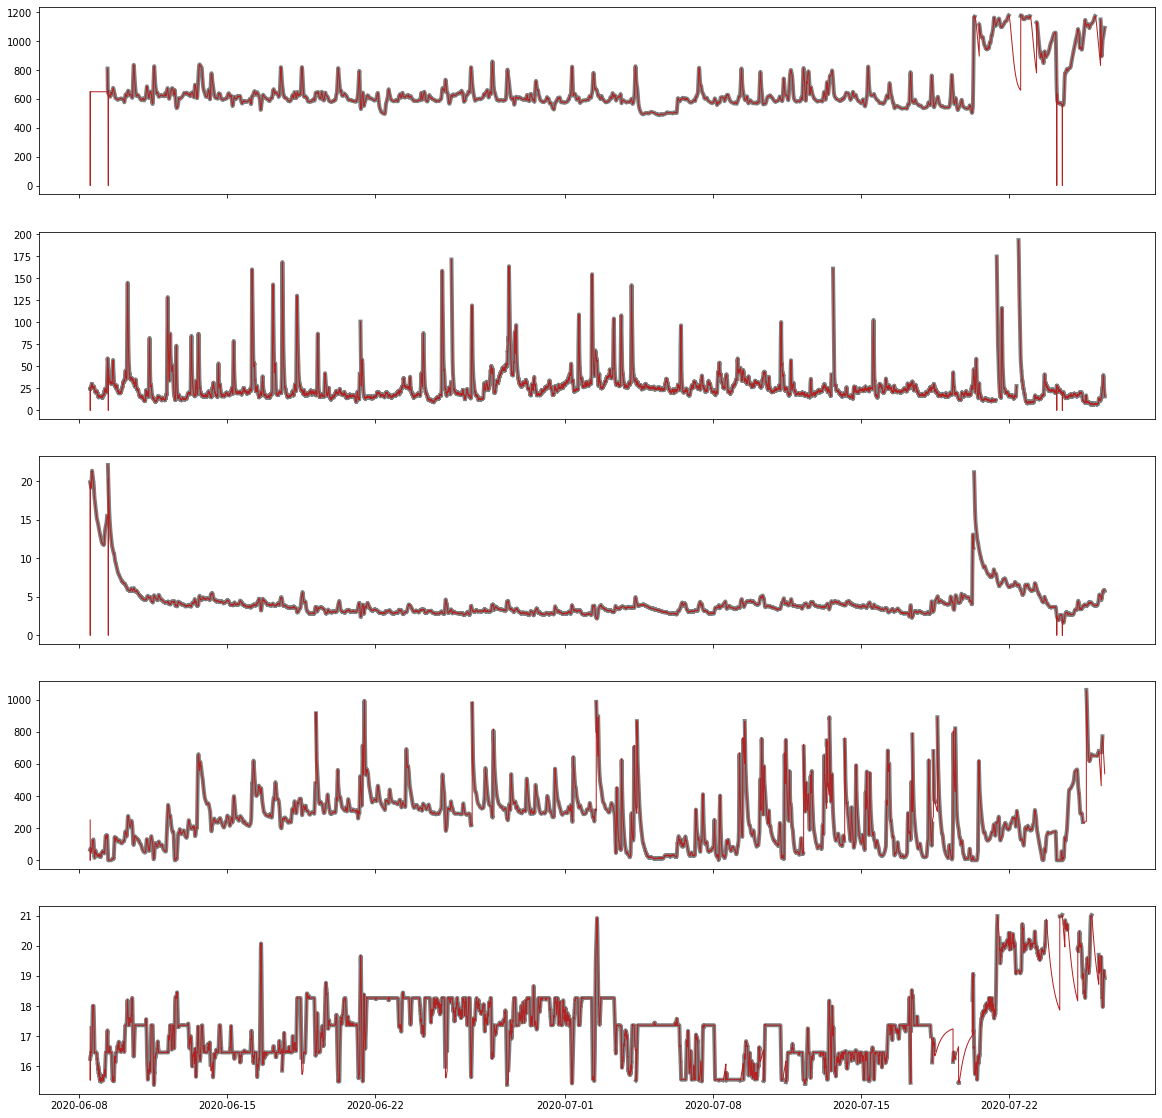

In [35]:
df_bb = data[data["beacon"] == 1]
compare_imputed(df_bb,check)

In [ ]:
    imp.fit(df_bb)
    self.rf_imputed = pd.DataFrame(imp.transform(self.missing),index=self.missing.index,columns=self.missing.columns)
    self.rf_imputed[self.rf_imputed < 0] = 0

In [12]:
data

,tvoc,co,co2,pm2p5_mass,pm10_mass,temperature_c,beacon
timestamp,,,,,,,
2020-06-08 13:00:00,65.783786,19.834244,NaN,24.767709,1.935866,16.244700,1
2020-06-08 13:02:00,65.973889,19.815803,NaN,25.379307,1.940782,16.257887,1
2020-06-08 13:04:00,66.832566,19.799258,NaN,24.874103,1.937115,16.269523,1
2020-06-08 13:06:00,67.746837,19.775693,NaN,24.503767,1.933971,16.279865,1
2020-06-08 13:08:00,68.488233,19.761017,NaN,24.824221,1.936699,16.289119,1
...,...,...,...,...,...,...,...
2020-08-26 23:52:00,NaN,NaN,NaN,NaN,NaN,NaN,46
2020-08-26 23:54:00,NaN,NaN,NaN,NaN,NaN,NaN,46
2020-08-26 23:56:00,NaN,NaN,NaN,NaN,NaN,NaN,46


[Back to Pre-Processing](#pre_processing)

---

<a id='remove_periods_random'></a>

[Back to ToC](#toc)
# Remove Periods at Random
Rather than remove single data points, we can remove gaps of data from the dataframe.

See the question [here](https://stackoverflow.com/questions/69290810/remove-n-consecutive-non-overlapping-rows-at-random-from-pandas-dataframe-in-py) for more of an explanation of the function below:

[Back to Remove Periods at Random](#inspection)

---

<a id='inspection'></a>

[Back to ToC](#ToC)
# Inspection
Now that we have generated the random datasets, we want to make sure they actually follow what they say.

[Back to Inspection](#inspection)

---

<a id='save'></a>

[Back to ToC](#toc)
# Save
To ensure the proper naming of the dataset when saving, we will create a pipeline in the following cells to re-runs the code above for each participant.

<a id='effecs'></a>

[Back to Analysis](#analysis)

---

<a id='ieq_and_mood'></a>